In [249]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import math

In [250]:
numCellsX, numCellsY = 100, 100
gridXLength = gridYLength = 1.0
cellXLength = gridXLength / numCellsX
cellYLength = gridYLength / numCellsY
gravity = 1.0
layerDepth = 1.0
fastestSignalSpeed = math.sqrt(gravity * layerDepth)
height = np.full((numCellsY, numCellsX), layerDepth)
xVelocity = np.zeros((numCellsY, numCellsX))
yVelocity = np.zeros((numCellsY, numCellsX))
bumpAltitude = 0.1
bumpWidth = 0.1 * gridXLength
bumpCenterX, bumpCenterY = 0.7, 0.7
bottomTopography = np.zeros((numCellsY, numCellsX))
coriolis = np.zeros((numCellsY, numCellsX))
CFL = 0.2
maxSpeed = np.maximum(np.abs(xVelocity) + fastestSignalSpeed, np.abs(yVelocity) + fastestSignalSpeed).max()
dt = CFL * min(cellXLength, cellYLength) / maxSpeed
dt0 = CFL * min(cellXLength, cellYLength) / fastestSignalSpeed
nSteps = 2000
outputEvery = 10
startingMass = height.sum()
averageNeighborMultiple = 0.001

In [251]:
x = np.linspace(0, gridXLength, numCellsX)
y = np.linspace(0, gridYLength, numCellsY)
X, Y = np.meshgrid(x, y, indexing="xy")
numerator = (X - bumpCenterX)**2 + (Y - bumpCenterY)**2
denominator = 2 * bumpWidth**2
height = layerDepth + bumpAltitude * np.exp(-numerator**2/denominator)
height

array([[1.        , 1.        , 1.        , ..., 1.00000001, 1.00000001,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.00000002, 1.00000002,
        1.00000001],
       [1.        , 1.        , 1.        , ..., 1.00000005, 1.00000003,
        1.00000002],
       ...,
       [1.00000001, 1.00000002, 1.00000005, ..., 1.02935322, 1.02677974,
        1.02426769],
       [1.00000001, 1.00000002, 1.00000003, ..., 1.02677974, 1.02435112,
        1.02199135],
       [1.        , 1.00000001, 1.00000002, ..., 1.02426769, 1.02199135,
        1.01978987]])

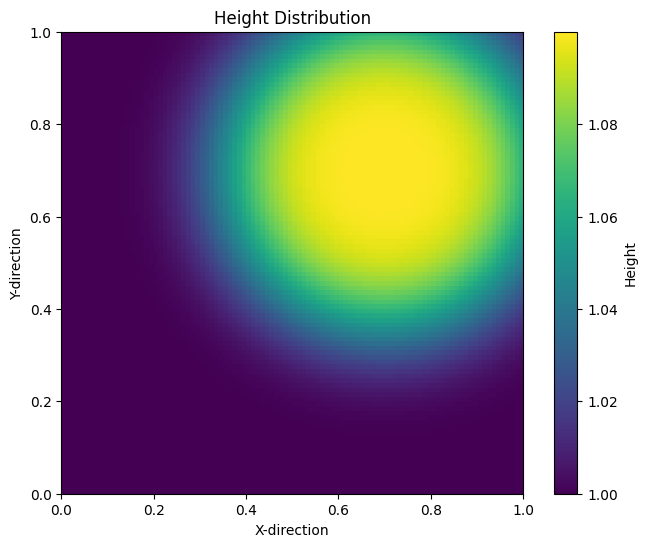

In [252]:
def plotHeight():
    plt.figure(figsize=(8, 6))
    plt.imshow(height, extent=[0, gridXLength, 0, gridYLength], origin='lower', cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Height Distribution')
    plt.xlabel('X-direction')
    plt.ylabel('Y-direction')
    plt.show()
plotHeight()

In [253]:
def upwindFace(varCell_I, varCell_I_PlusOne, velocityCell_I, velocityCell_I_PlusOne):
    both_pos = (velocityCell_I >= 0) & (velocityCell_I_PlusOne >= 0)
    both_neg = (velocityCell_I < 0) & (velocityCell_I_PlusOne < 0)
    return np.where(both_pos, varCell_I,
           np.where(both_neg, varCell_I_PlusOne, 0.5 * (varCell_I + varCell_I_PlusOne)))

def rollLeft(arr):
    return np.roll(arr, -1, axis=1)

def rollRight(arr):
    return np.roll(arr, 1, axis=1)

def rollUp(arr):
    return np.roll(arr, -1, axis=0)

def rollDown(arr):
    return np.roll(arr, 1, axis=0)

def laplacian(field):
    return (
        rollLeft(field) + rollRight(field) +
        rollUp(field)   + rollDown(field) -
        4.0 * field
    )


In [254]:
def step(height, xVelocity, yVelocity, dt):
    massFluxX = height * xVelocity
    massFluxY = height * yVelocity
    massFluxXInX = massFluxX**2 + 0.5 * gravity * height**2
    massFluxXInY = height * xVelocity * yVelocity
    massFluxYInY = massFluxY**2 + 0.5 * gravity * height**2
    massFluxYInX = height * xVelocity * yVelocity

    xVelocityLeft = xVelocity
    xVelocityRight = rollLeft(xVelocity) # to get right cell have to roll array left
    xVelocityHeightFace = upwindFace(height, rollLeft(height), xVelocityLeft, xVelocityRight)
    xVelocityXFace = upwindFace(xVelocityLeft, xVelocityRight, xVelocityLeft, xVelocityRight)
    xVelocityYFace = upwindFace(yVelocity, rollLeft(yVelocity), xVelocityLeft, xVelocityRight)


    yVelocityBottom = yVelocity
    yVelocityTop = rollDown(yVelocity) # to get top cell have to roll down
    yVelocityHeightFace = upwindFace(height, rollDown(height), yVelocityBottom, yVelocityTop)
    yVelocityXFace = upwindFace(xVelocity, rollDown(xVelocity), yVelocityBottom, yVelocityTop)
    yVelocityYFace = upwindFace(yVelocityBottom, yVelocityTop, yVelocityBottom, yVelocityTop)

    fluxHeightX = xVelocityHeightFace * xVelocityXFace
    fluxXMomentumX = xVelocityHeightFace * xVelocityXFace * xVelocityXFace + 0.5 * gravity * xVelocityHeightFace * xVelocityHeightFace
    fluxYMomentumX = xVelocityHeightFace * xVelocityXFace * xVelocityYFace

    fluxHeightY = yVelocityHeightFace * yVelocityYFace
    fluxXMomentumY = yVelocityHeightFace * yVelocityXFace * yVelocityYFace
    fluxYMomentumY = yVelocityHeightFace * yVelocityYFace * yVelocityYFace + 0.5 * gravity * yVelocityHeightFace * yVelocityHeightFace

    newHeight = height - (dt/cellXLength) * (fluxHeightX - rollRight(fluxHeightX)) - (dt/cellYLength) * (fluxHeightY - rollUp(fluxHeightY))

    newMassFluxX = massFluxX - (dt/cellXLength) * (fluxXMomentumX - rollRight(fluxXMomentumX)) - (dt/cellYLength) * (fluxYMomentumX - rollUp(fluxYMomentumX))
    newMassFluxY = massFluxY - (dt/cellXLength) * (fluxXMomentumY - rollRight(fluxXMomentumY)) - (dt/cellYLength) * (fluxYMomentumY - rollUp(fluxYMomentumY))

    newHeight     = newHeight     + averageNeighborMultiple * laplacian(newHeight)
    newMassFluxX  = newMassFluxX  + averageNeighborMultiple * laplacian(newMassFluxX)
    newMassFluxY  = newMassFluxY  + averageNeighborMultiple * laplacian(newMassFluxY)

    newHeight = np.maximum(newHeight, 1e-9)
    newXVelocity = newMassFluxX / newHeight
    newYVelocity = newMassFluxY / newHeight

    return newHeight, newXVelocity, newYVelocity

Step: 0


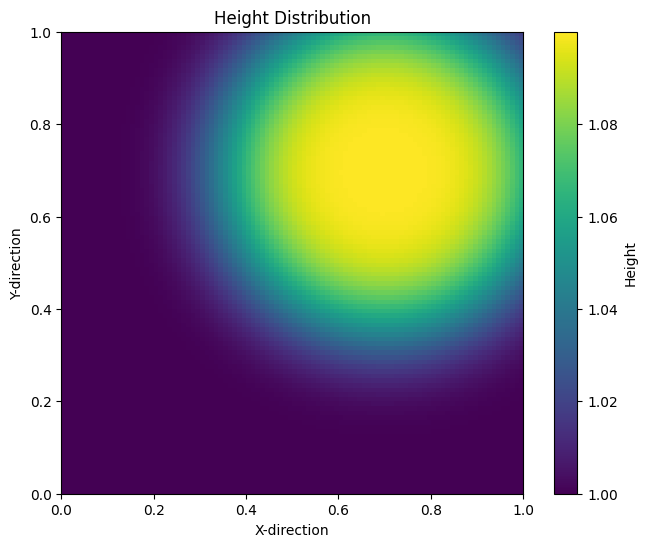

Step: 10


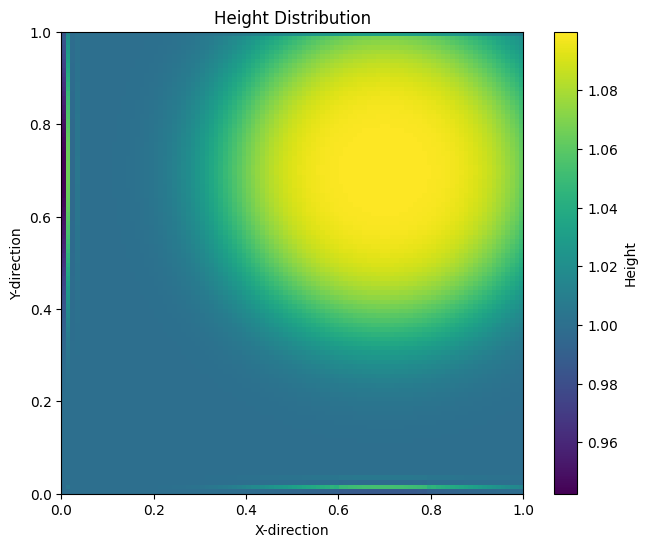

Step: 20


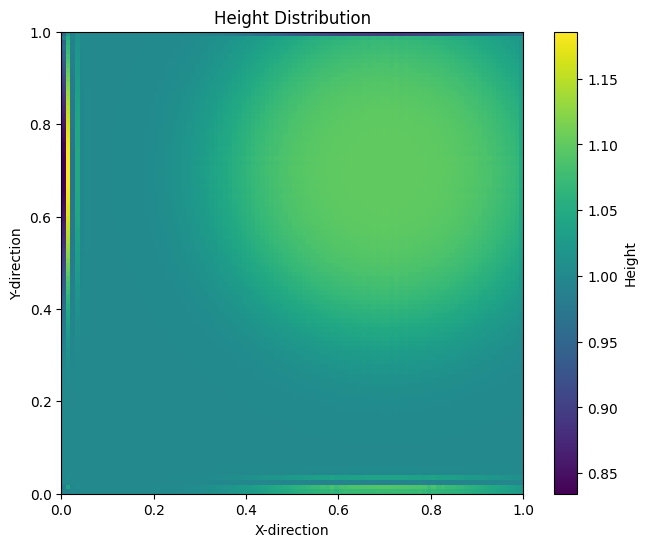

Step: 30


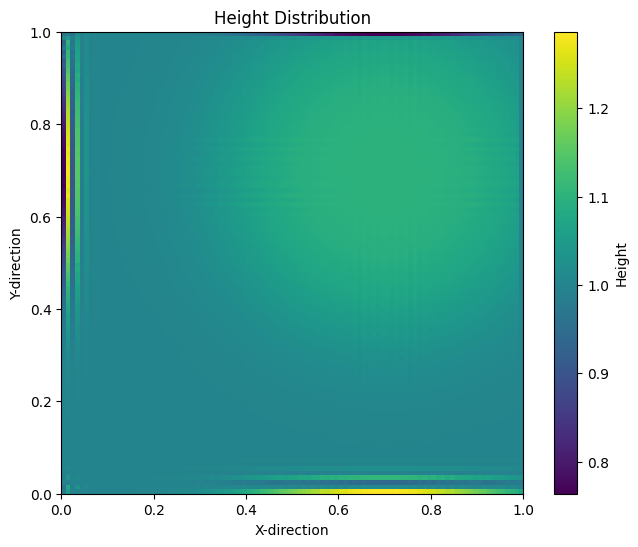

Step: 40


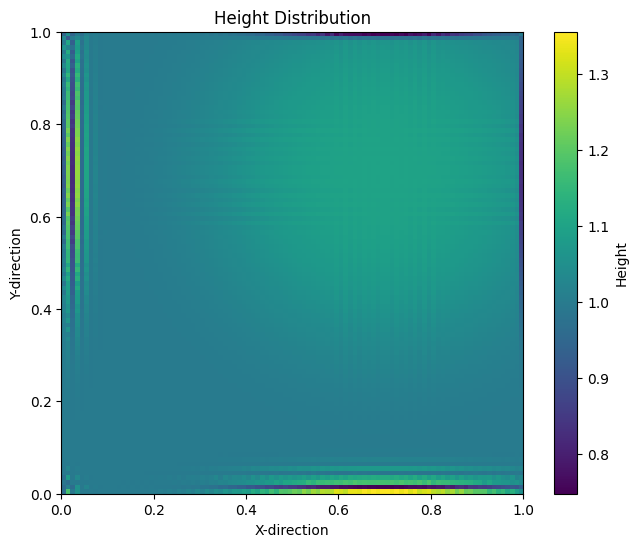

Step: 50


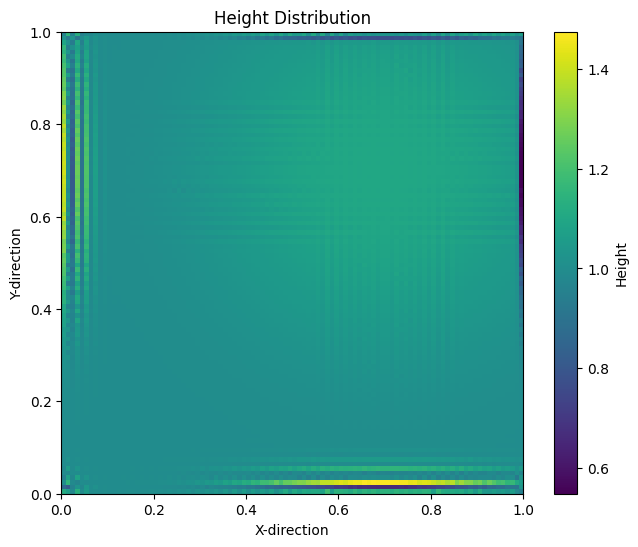

Step: 60


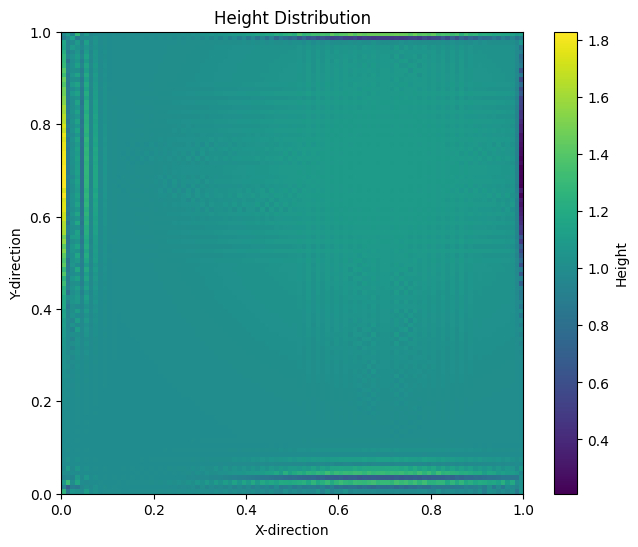

Step: 70


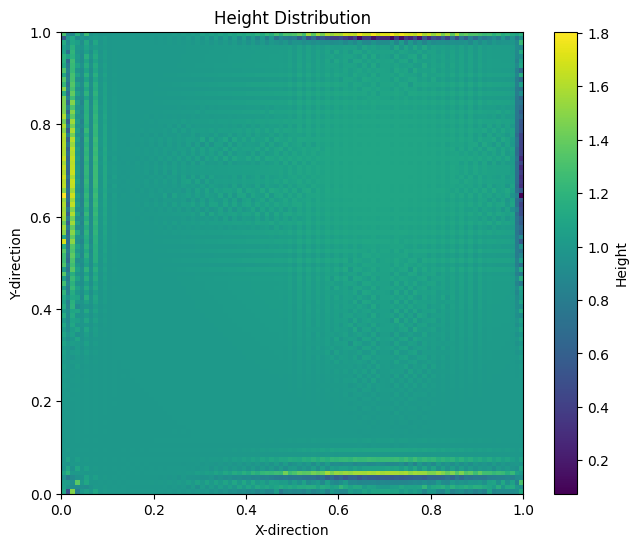

Step: 80


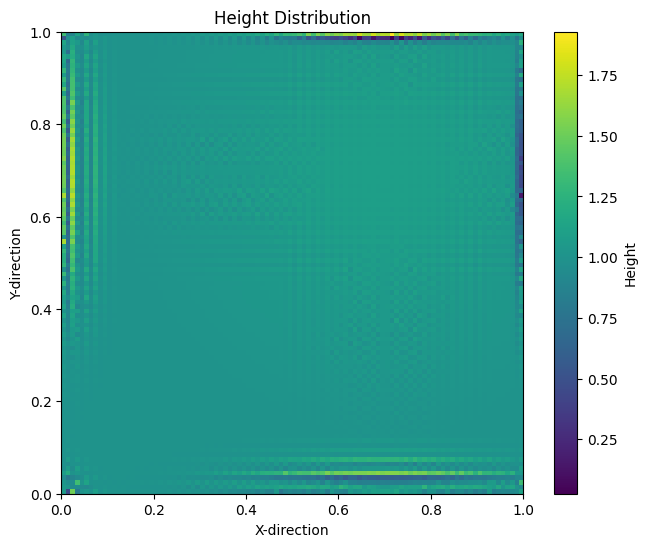

Step: 90


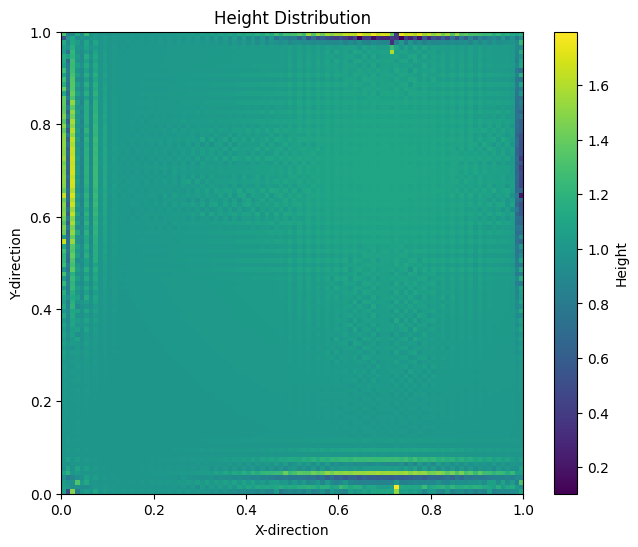

Step: 100


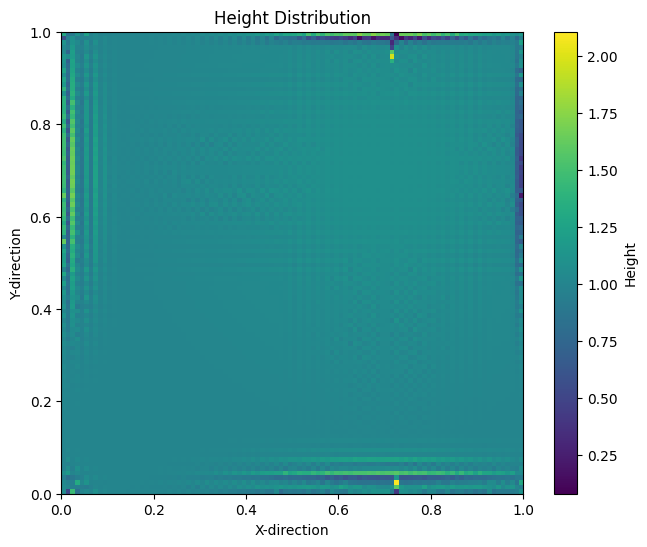

Step: 110


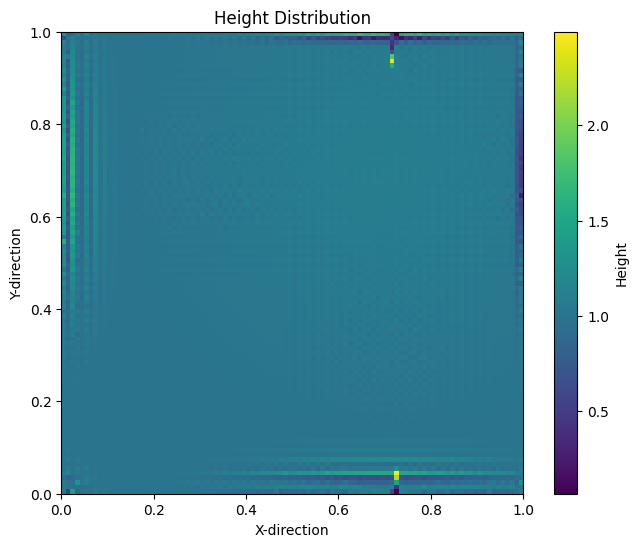

Step: 120


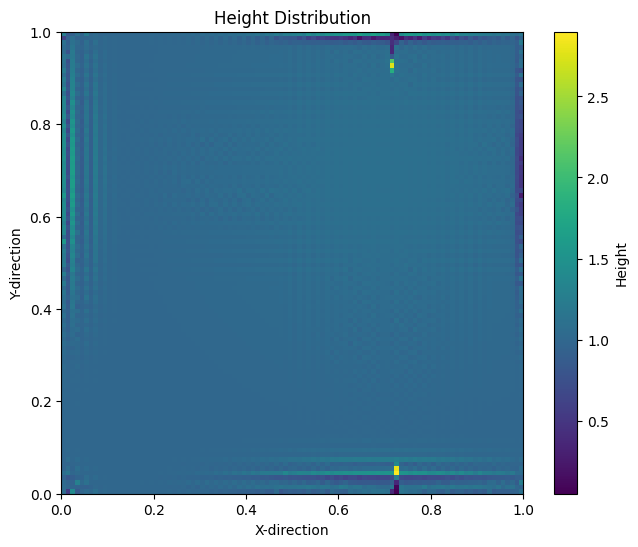

Step: 130


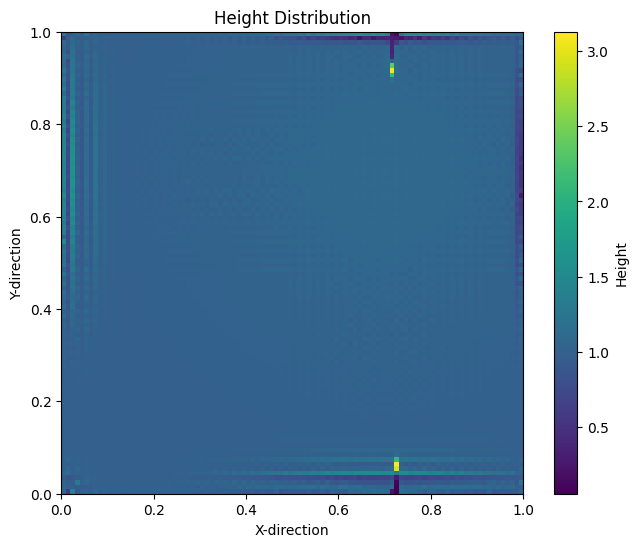

Step: 140


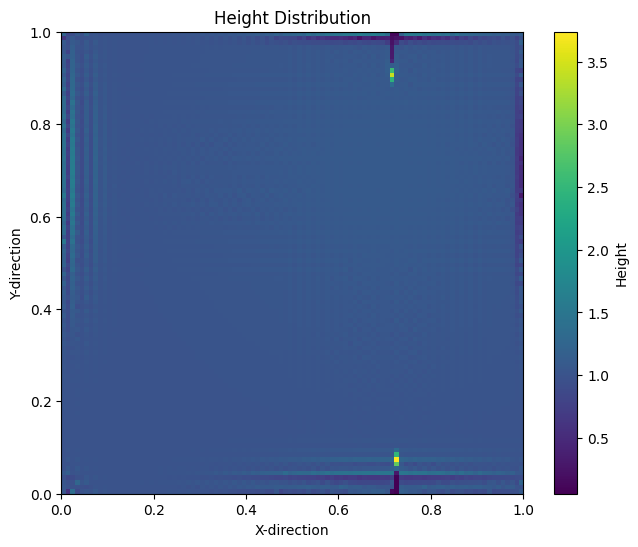

Step: 150


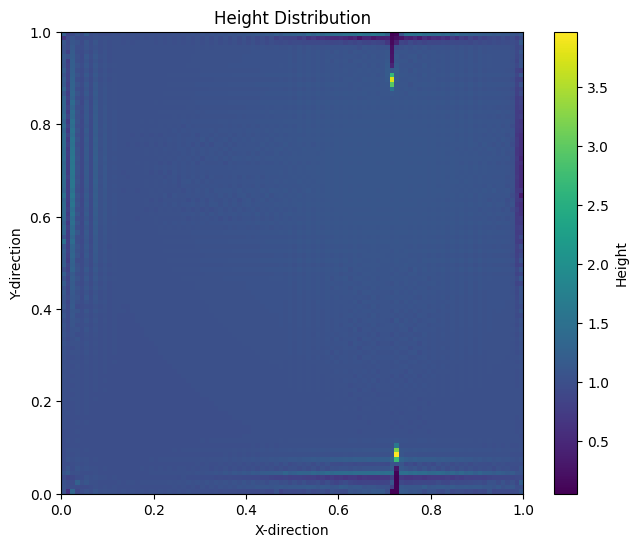

Step: 160


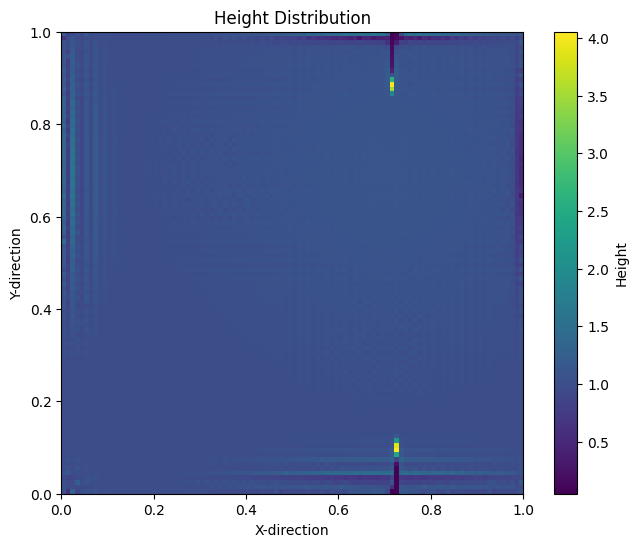

Step: 170


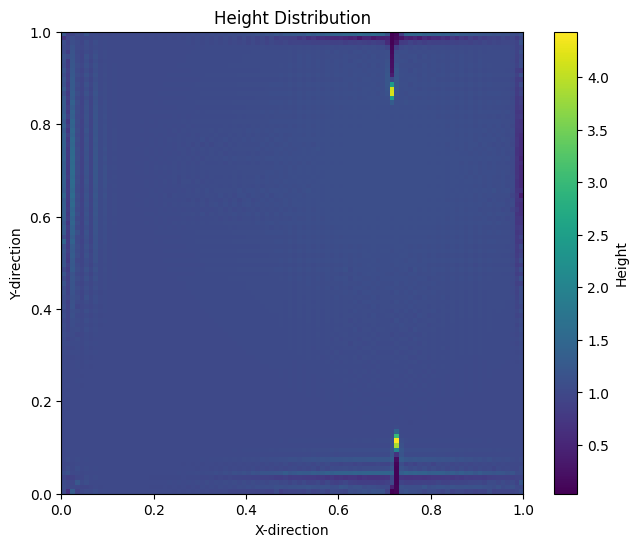

Step: 180


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


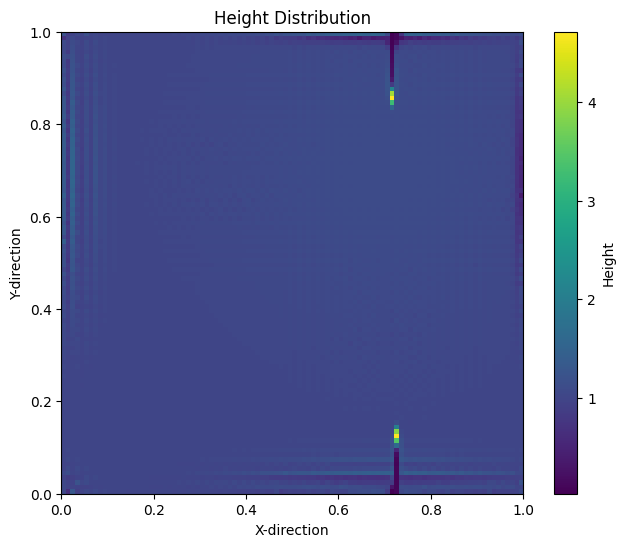

Step: 190


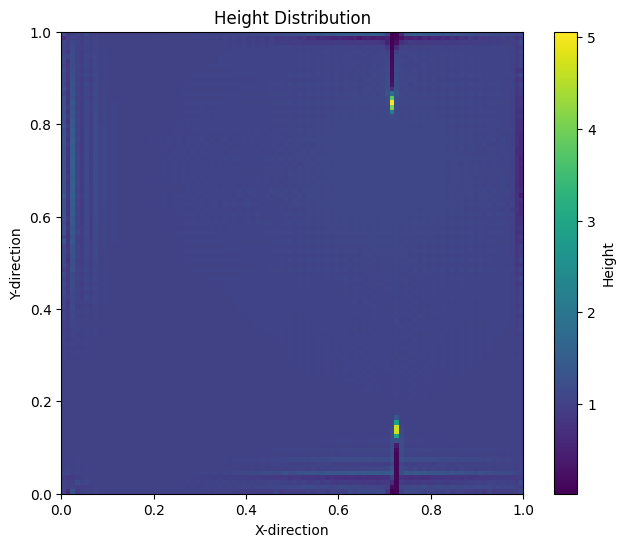

Step: 200


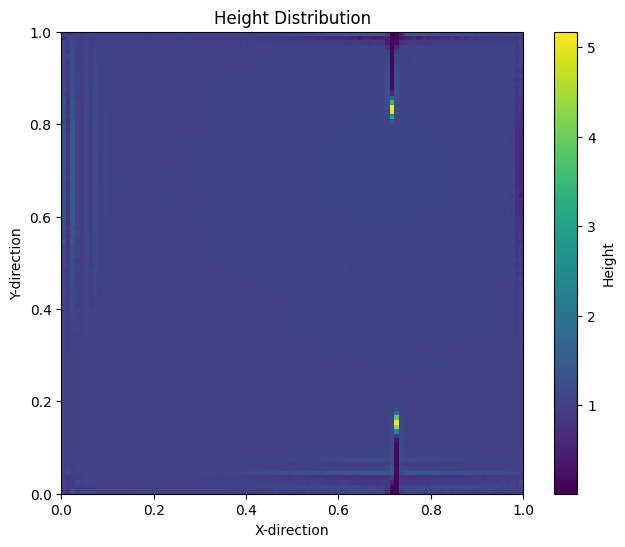

Step: 210


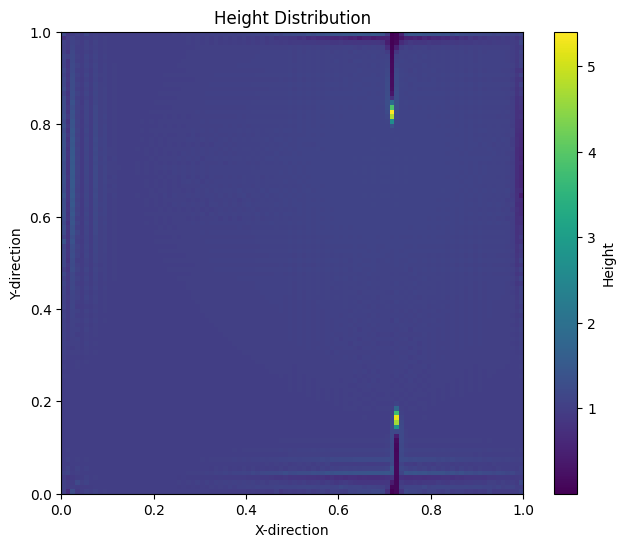

Step: 220


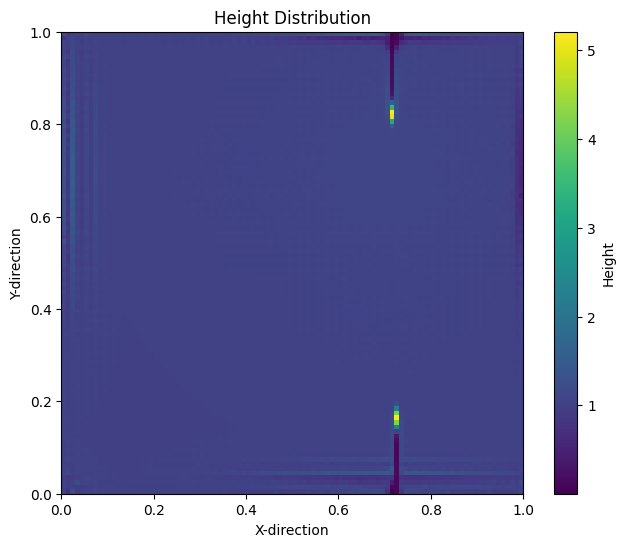

Step: 230


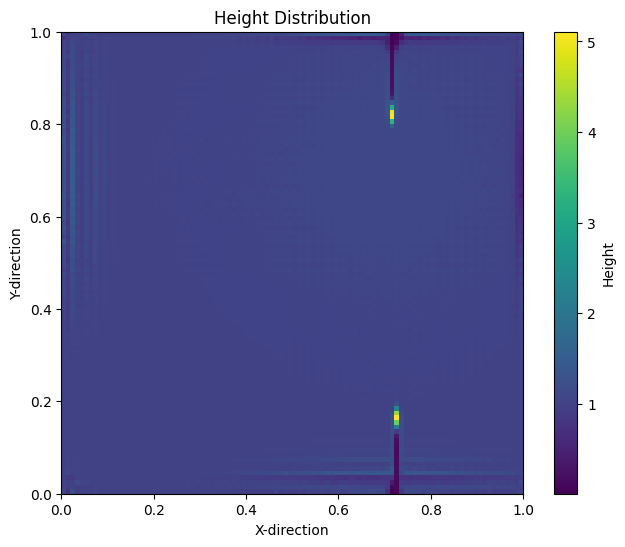

Step: 240


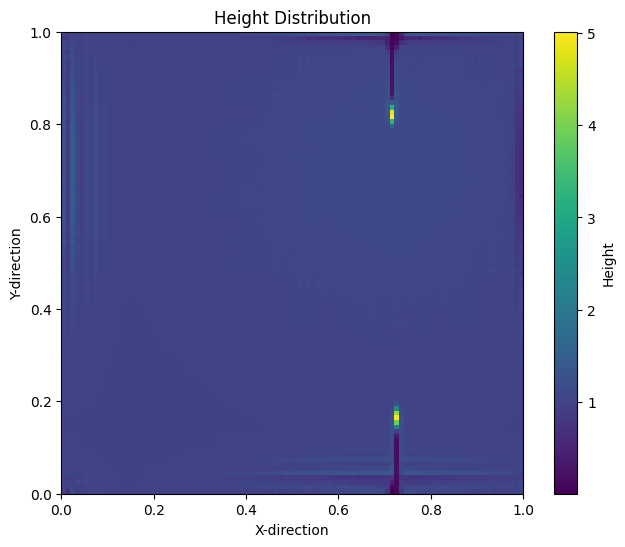

Step: 250


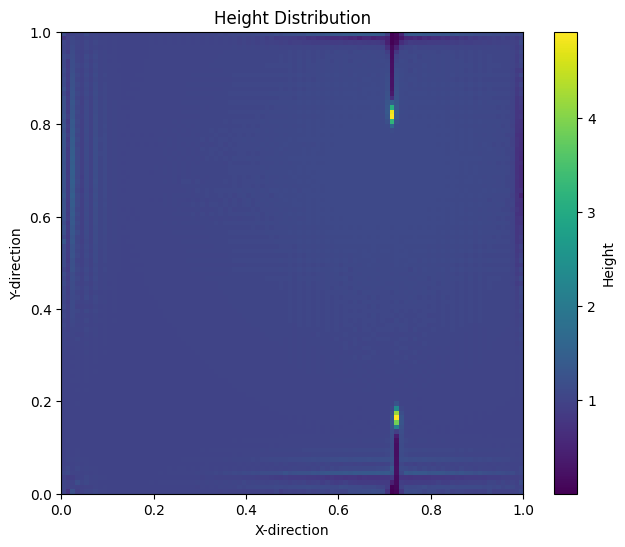

Step: 260


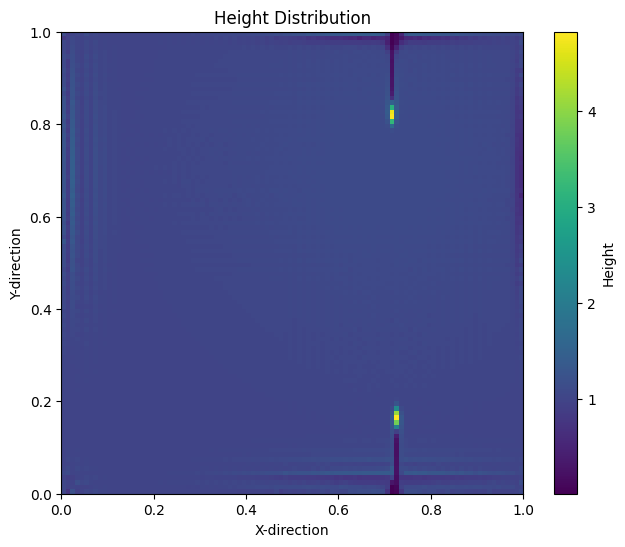

Step: 270


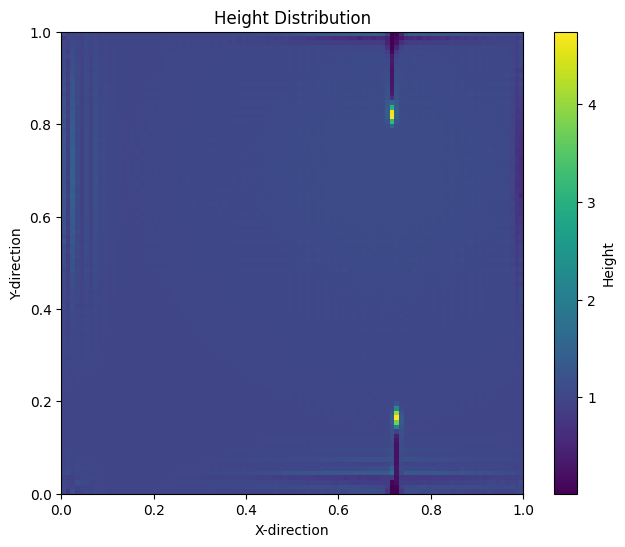

Step: 280


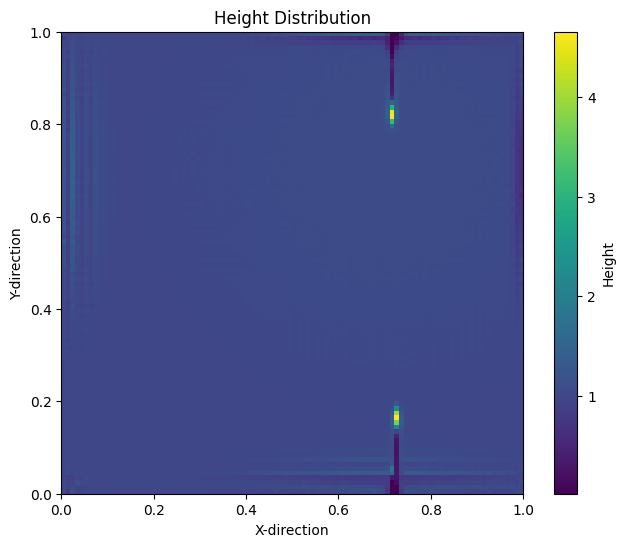

Step: 290


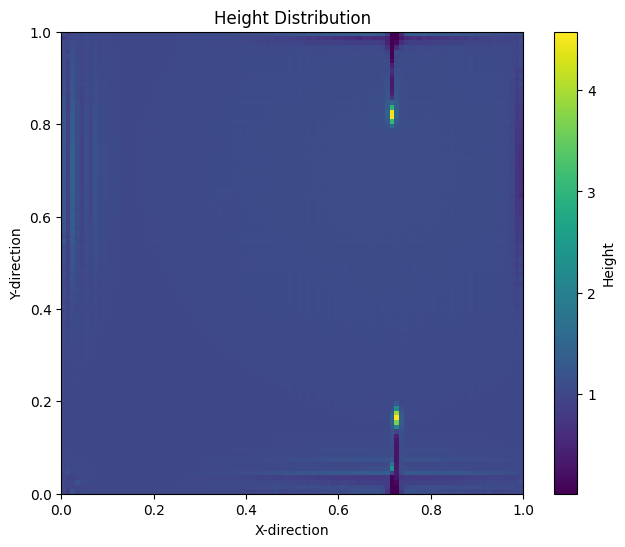

Step: 300


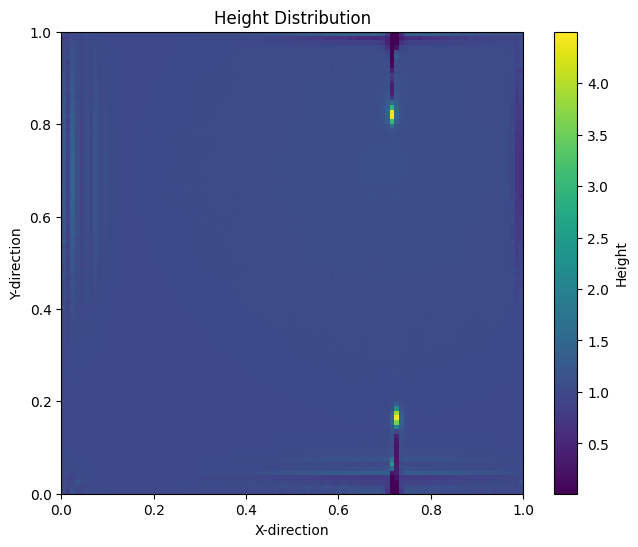

Step: 310


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

In [255]:
for i in range(nSteps):
    localWaveSpeed = np.sqrt(gravity * height)
    maxSignal = np.maximum(np.abs(xVelocity) + localWaveSpeed, np.abs(yVelocity) + localWaveSpeed).max()
    dt = CFL * min(cellXLength, cellYLength) / maxSignal

    height, xVelocity, yVelocity = step(height, xVelocity, yVelocity, dt)

    if i % outputEvery == 0:
        print(f"Step: {i}")
        plotHeight()